In [1]:
"""
*******************************
* 1. Look at teh big picture  *
*******************************

Task: build a model of housing prices in California using the california census data

(1) Frame the problem
a. supervised learning as the data has target label
b. regression as it is to predict a value
c. plain batch learning

(2) Select a performance measure
a. RMSE: Root Mean Square Error
b. MAE: Mean Absolute Error

(3) check the assumptions
a. Downsteam system needs actual prices, not just categories, so it is regression not classification

"""


'\n*******************************\n* 1. Look at teh big picture  *\n*******************************\n\nTask: build a model of housing prices in California using the california census data\n\n(1) Frame the problem\na. supervised learning as the data has target label\nb. regression as it is to predict a value\nc. plain batch learning\n\n(2) Select a performance measure\na. RMSE: Root Mean Square Error\nb. MAE: Mean Absolute Error\n\n(3) check the assumptions\na. Downsteam system needs actual prices, not just categories, so it is regression not classification\n\n'

In [2]:
"""
********************
* 2. Get the data  *
********************

(1) Download the data
(2) Take a quick look at the data structure
(3) Crate a test set

"""

#Step 1: Download the data
#=========================

#Fetach data from website and save it to local disk
#This is a helper funciton to automate data file download from Internet
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()




fetch_housing_data()

In [3]:
#Step 2: Take a quick look at the data structure
#========================

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [4]:
#a. Top five records
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
#b. data set quick description 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
#c. value_counts by category attribute
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#d. describe() - a summary of the numerical attributes

#std: standard deviation
#25%,50%,75%: Percentiles indicate the value below which a given percentage of observations in a group of observations falls

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


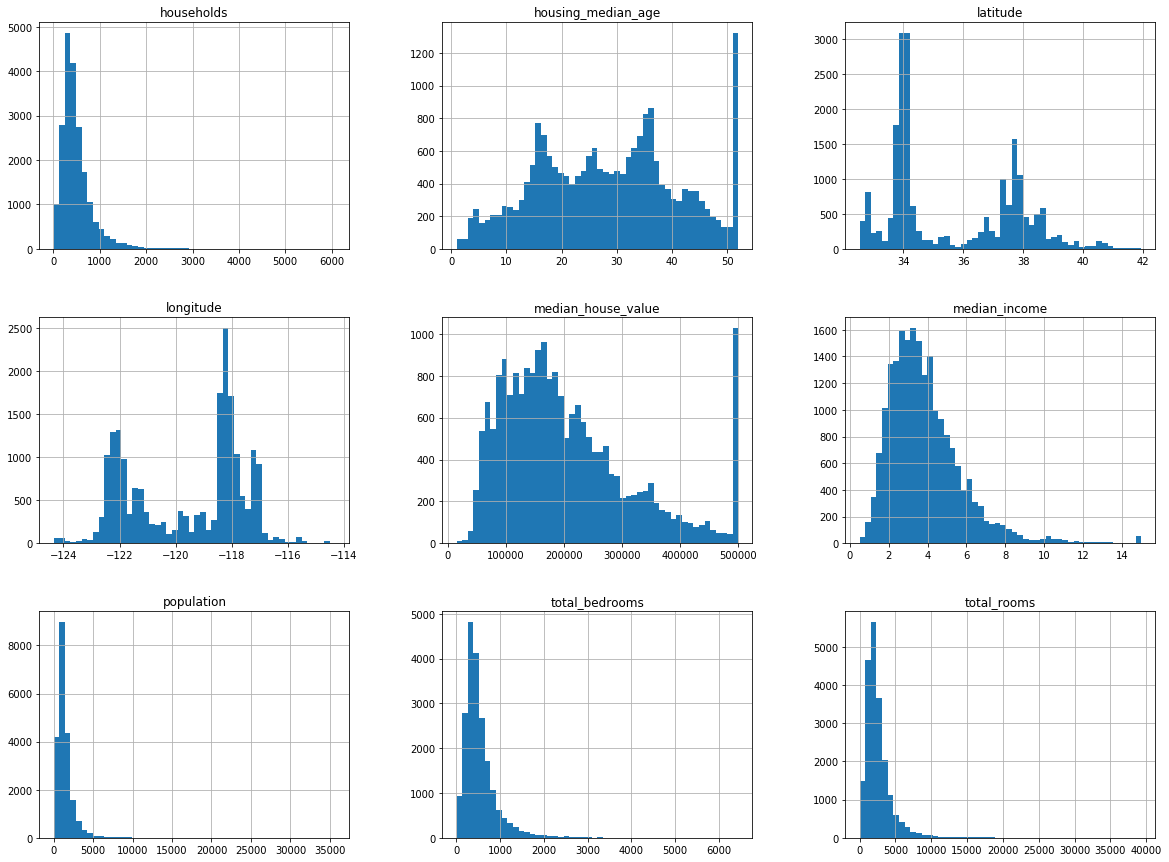

In [8]:
#e visulization - histogram for each numberical attributes 

%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [9]:
#Step 3: Create a test set
#============================

#a. Option 1: pick some instances radnomly, typically 20% of the dataset
#Issue: everytime run the same funciton will get different set of testing data, overtime ML will get to see all the data
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [11]:
#b. Option 2: set random number generator's seed to make sure function retrun same test set

# random_state=42
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [12]:
train_set1, test_set1 = train_test_split(housing, test_size=0.2, random_state=42)


In [13]:
print(test_set.equals(test_set1))

True


In [14]:
print(train_set.equals(train_set1))

True


In [15]:
#c. Option 3: purely random sampling is good when the dataset is large enough
"""if the data set is not large enough, pure random sampling will introuce a signifcant samping gias
soluiton: Stratified Sampling

1. devide the data set into homogeneous subgroups called Strata, 
2. the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population

"""
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

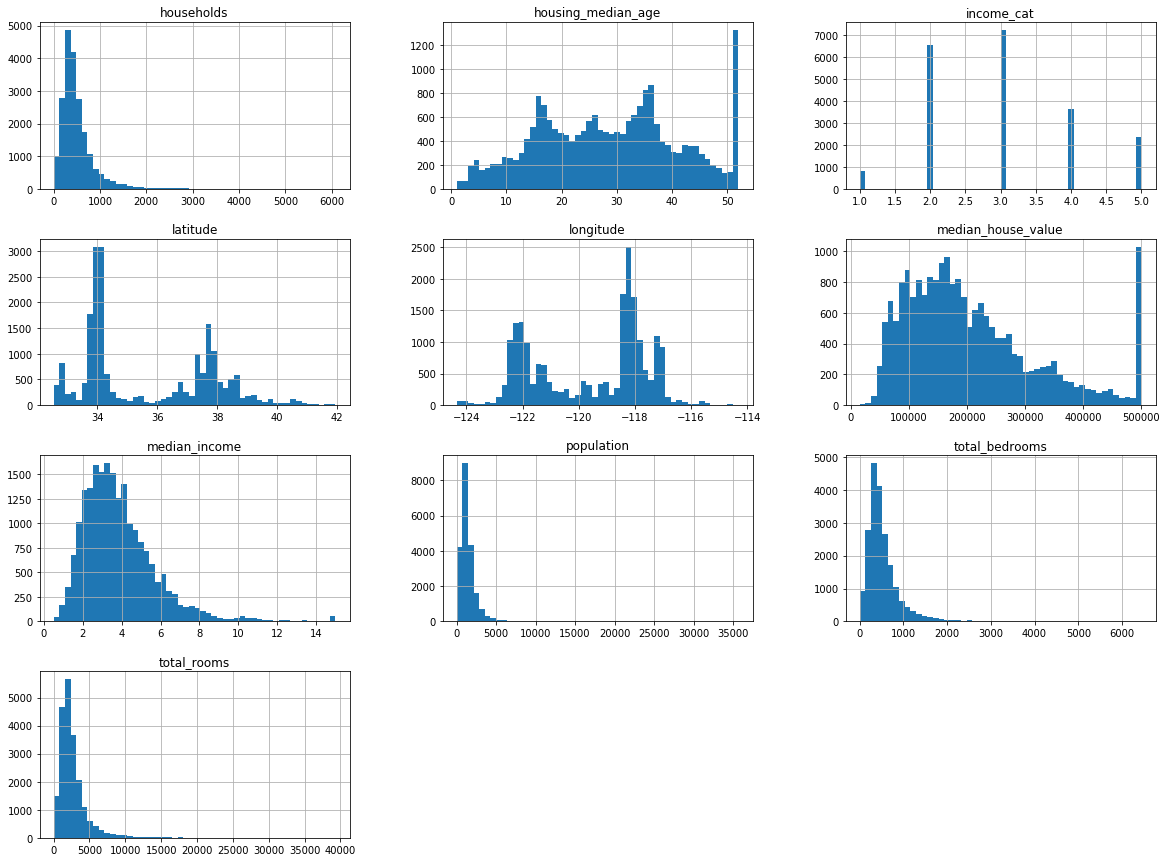

In [16]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

i=0
for train_index, test_index in split.split(housing, housing["income_cat"]):
    print("Loop #", i)
    i = i + 1
    print("Train:", train_index, "\n", "Test:", test_index)
    strat_train_set = housing.loc[train_index]
    print(strat_train_set.info())
    strat_test_set = housing.loc[test_index]
    print(strat_test_set.info())


Loop # 0
Train: [17606 18632 14650 ... 13908 11159 15775] 
 Test: [ 5241 10970 20351 ...  4019 12107  2398]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 11 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 11 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 no

In [18]:
strat_test_set.info()
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 11 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households            4128 non-null float64
median_income         4128 non-null float64
median_house_value    4128 non-null float64
ocean_proximity       4128 non-null object
income_cat            4128 non-null float64
dtypes: float64(10), object(1)
memory usage: 387.0+ KB


3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [19]:
strat_train_set.info()
strat_train_set["income_cat"].value_counts()/len(strat_train_set)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 11 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
income_cat            16512 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.5+ MB


3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [20]:
housing.info()
housing["income_cat"].value_counts()/len(housing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
income_cat            20640 non-null float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB


3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [21]:
"""Remove the income_cat"""

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
strat_train_set.info()
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4128 entries, 5241 to 2398
Data columns (total 10 columns):
longitude             4128 non-null float64
latitude              4128 non-null float64
housing_median_age    4128 non-null float64
total_rooms           4128 non-null float64
total_bedrooms        4079 non-null float64
population            4128 non-null float64
households  

Traing set:


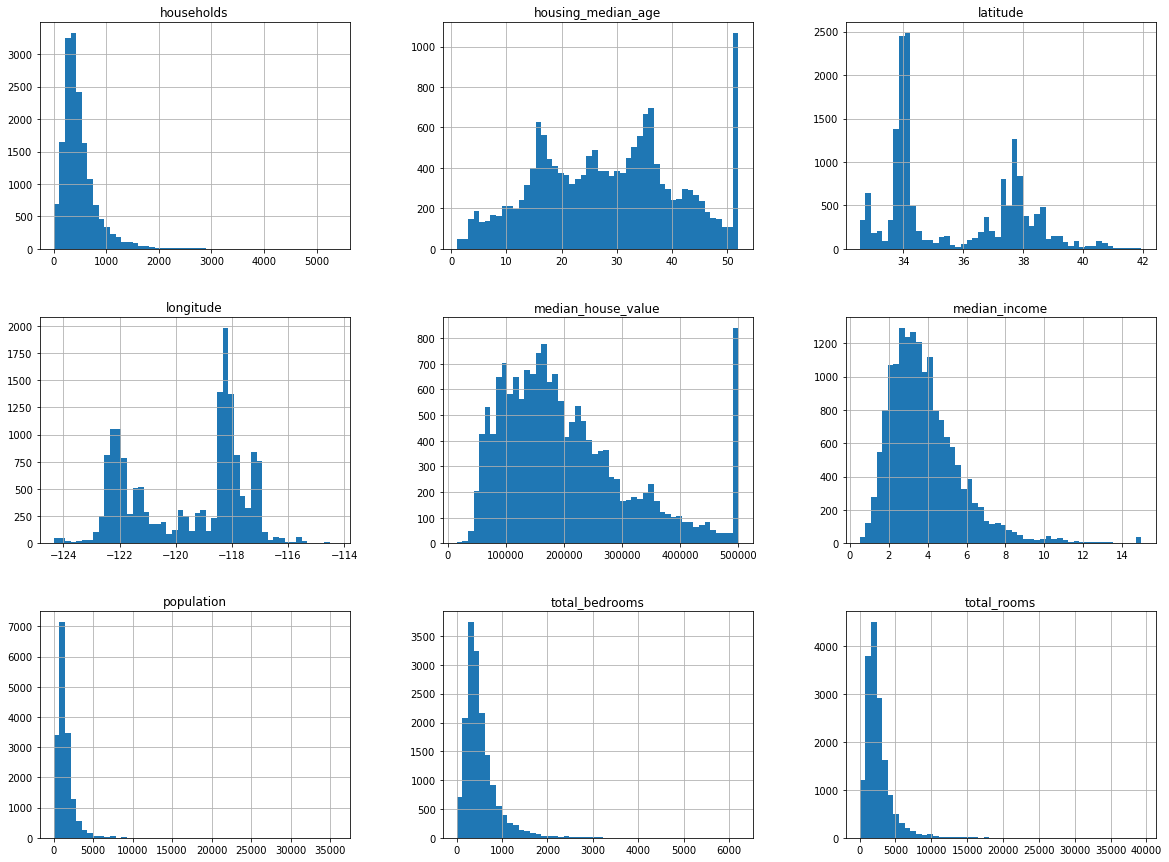

Test set:


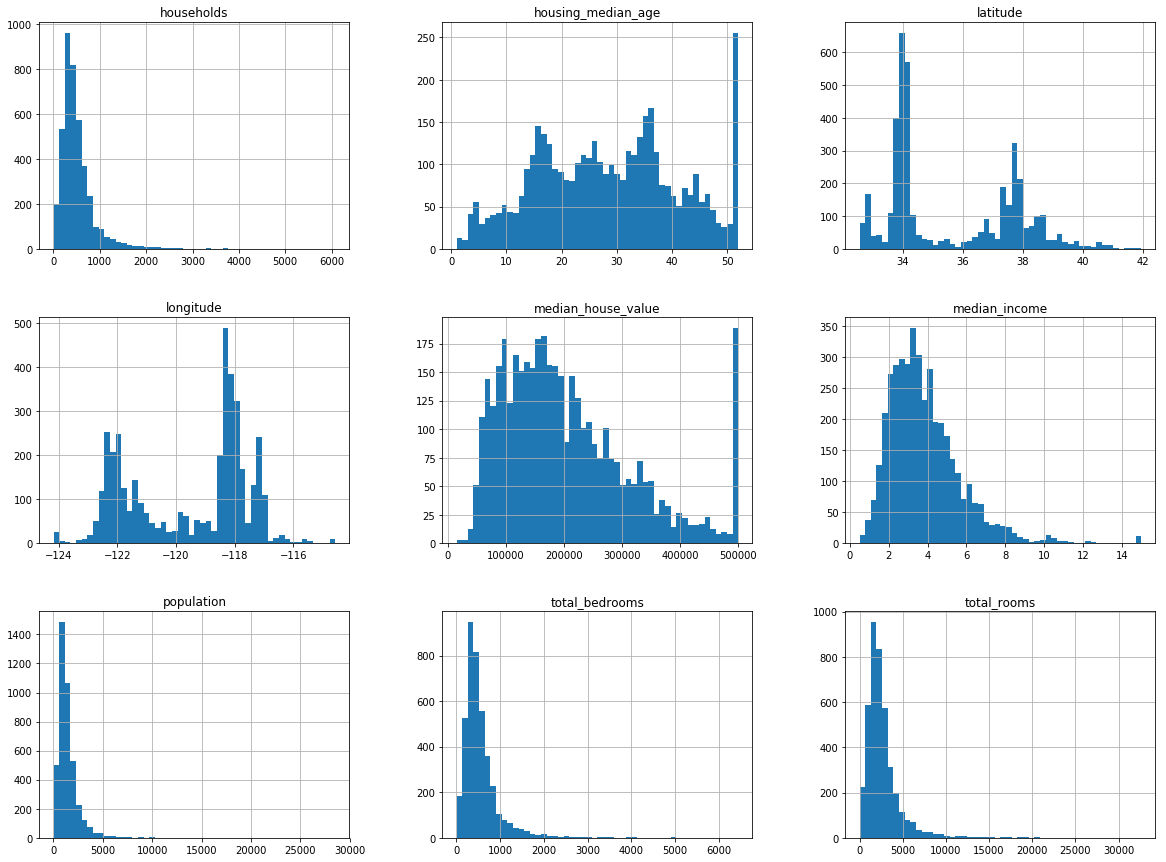

In [22]:
print("Traing set:")
strat_train_set.hist(bins=50, figsize=(20,15))
plt.show()

print("Test set:")
strat_test_set.hist(bins=50,figsize=(20,15))
plt.show()

In [23]:
"""
*******************************************************
* 3. Discover and visualize the data to gain insights *
*******************************************************

(1) Visualize geographical data
(2) Looking for correlations
(3) Experimenting with attribute combinations

"""

# makde a copy of the training set

housing = strat_train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


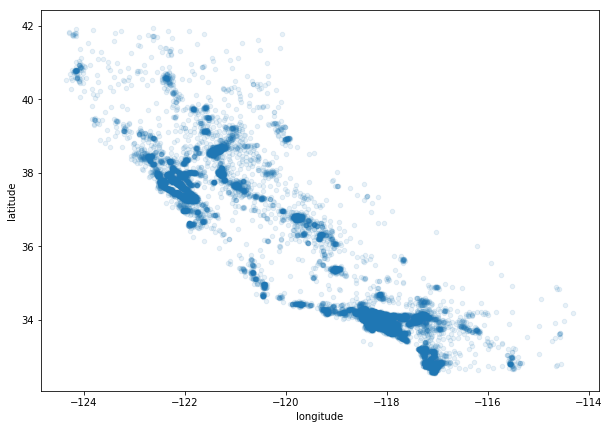

In [24]:
# Step 1. Visualizing geographical data

#scatterplot

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,7))
plt.show()

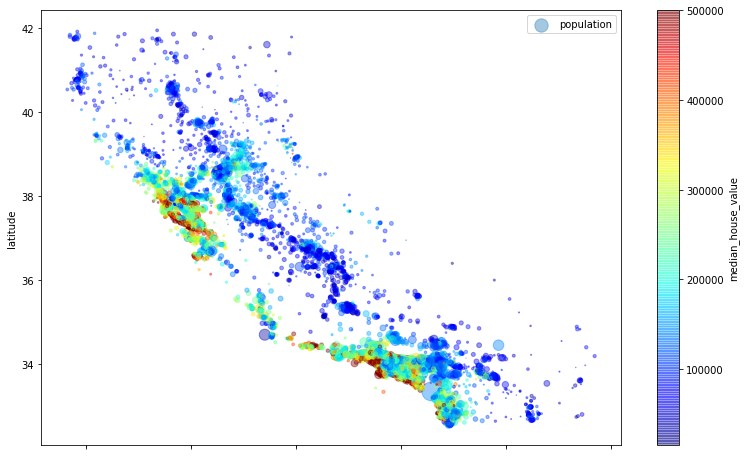

In [25]:
#The image tells that the housing prices are very much related to the 
# - Location 
# - Population density

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(13,8),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [26]:
#Step 2: Looking for correlations

#Standard corelation coefficient - also called Pearson's r
# The correlation coefficient ranges from -1 to 1. when it is close to 1, it means that there is a strong positive correlation
# When the coefficient is close to 01, it means that this ia a strong negative correlation

corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f2086d8>,
      dtype=object)

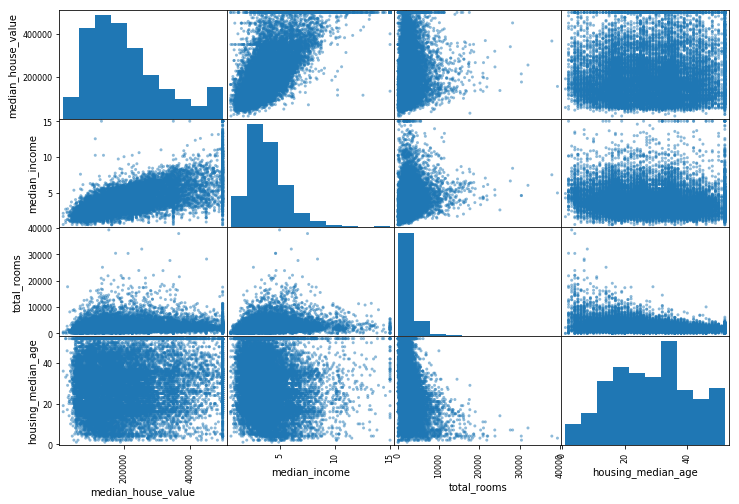

In [27]:
#Another way to check correlation

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

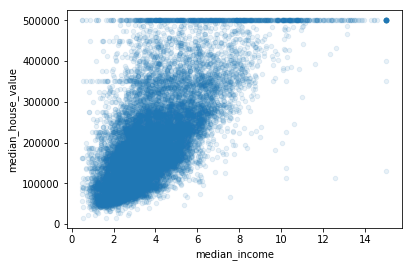

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [29]:
#Step 3: Experimenting with attribute combinations

"""
- Clean up data quirks
- Identify correlation betweeen attributes and target attribute
- Tail-heavy distribution to transform them - computing their logarithm
- Try various attribute combinations
"""

# example of attribute combination 

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

housing.info()

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 13 columns):
longitude                   16512 non-null float64
latitude                    16512 non-null float64
housing_median_age          16512 non-null float64
total_rooms                 16512 non-null float64
total_bedrooms              16354 non-null float64
population                  16512 non-null float64
households                  16512 non-null float64
median_income               16512 non-null float64
median_house_value          16512 non-null float64
ocean_proximity             16512 non-null object
rooms_per_household         16512 non-null float64
bedrooms_per_room           16354 non-null float64
population_per_household    16512 non-null float64
dtypes: float64(12), object(1)
memory usage: 1.8+ MB


median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [30]:
"""
*******************************************************
* 4. Prepare the data for machine learning algorithms *
*******************************************************

(1) Data cleaning
(2) Handling text and categorical attributes
(3) Cutsom transformers
(4) Feature scaling
(5) Transformation pipelines

"""

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()


In [31]:
#Step 1. Data clearning

#For missing values 
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [32]:
#Option 1. Get rid of the corresponsding districts
h1 = housing.dropna(subset=["total_bedrooms"])
housing.info()
print("-------------------------------------")
h1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16354 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16354 non-null float64
latitude              16354 non-null float64
housing_median_age    16354 non-null float64
total_rooms           16354 non-null float64
total_bedrooms        16354 non-null float64
population            16354 non-null float64
households  

In [33]:
#Option 2. Get rid of the whole attribute
h2 = housing.drop("total_bedrooms", axis=1)
housing.info()
print("----------------------------------")
h2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
----------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income  

In [34]:
#Option 3. Set the values to some value (zero, the mean, the median, etc)
median = housing["total_bedrooms"].median()
h3 = housing.copy()
h3["total_bedrooms"].fillna(median, inplace=True)
housing.info()
print("------------------------------")
h3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households         

In [35]:
#Option 4. Scikit-learn Imputer

from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

imputer.statistics_




/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [36]:
X = imputer.transform(housing_num)

In [37]:
print(X)

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [38]:
#convert X back to Pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
print(housing_tr)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -121.89     37.29                38.0       1568.0           351.0   
1        -121.93     37.05                14.0        679.0           108.0   
2        -117.20     32.77                31.0       1952.0           471.0   
3        -119.61     36.31                25.0       1847.0           371.0   
4        -118.59     34.23                17.0       6592.0          1525.0   
5        -120.97     37.66                24.0       2930.0           588.0   
6        -118.50     34.04                52.0       2233.0           317.0   
7        -117.24     34.15                26.0       2041.0           293.0   
8        -118.26     33.99                47.0       1865.0           465.0   
9        -118.28     34.02                29.0        515.0           229.0   
10       -121.31     38.02                24.0       4157.0           951.0   
11       -121.62     39.14                41.0      

In [39]:
#Step 2. Handling text and categorical attributes

housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [40]:
#Convert category value to numbers

housing_cat_encoded, housing_categories = housing_cat.factorize()

print(len(housing_cat_encoded))
print(housing_cat_encoded[:10])

housing_categories

#The issue of this solution is ML will assume that two nearby values are more simliar than two distant value; 
#for example: 0 (<1 H OCEAN) and 4 (ISLAND) are more close than 0 and 2 (INLAND)

16512
[0 0 1 2 0 2 0 2 0 0]


Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [41]:
#Solution to the issue above: Create one binar attriburte per category - One-hot encoding 

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))


/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [42]:
print(housing_cat_1hot[:200])

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
  (5, 2)	1.0
  (6, 0)	1.0
  (7, 2)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 2)	1.0
  (11, 2)	1.0
  (12, 0)	1.0
  (13, 2)	1.0
  (14, 2)	1.0
  (15, 0)	1.0
  (16, 3)	1.0
  (17, 2)	1.0
  (18, 2)	1.0
  (19, 2)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 2)	1.0
  (24, 2)	1.0
  :	:
  (175, 2)	1.0
  (176, 2)	1.0
  (177, 0)	1.0
  (178, 0)	1.0
  (179, 2)	1.0
  (180, 2)	1.0
  (181, 3)	1.0
  (182, 0)	1.0
  (183, 2)	1.0
  (184, 3)	1.0
  (185, 0)	1.0
  (186, 2)	1.0
  (187, 0)	1.0
  (188, 1)	1.0
  (189, 2)	1.0
  (190, 0)	1.0
  (191, 0)	1.0
  (192, 2)	1.0
  (193, 0)	1.0
  (194, 0)	1.0
  (195, 3)	1.0
  (196, 2)	1.0
  (197, 2)	1.0
  (198, 3)	1.0
  (199, 0)	1.0


In [43]:
a = housing_cat_1hot.toarray()
print(len(a))
a

16512


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [44]:
"""
#Combine the two transformation togehter by using CategoricalEncoder

from sklearn.preprocessing import CategoricalEncoder 

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)

"""

'\n#Combine the two transformation togehter by using CategoricalEncoder\n\nfrom sklearn.preprocessing import CategoricalEncoder \n\ncat_encoder = CategoricalEncoder()\nhousing_cat_reshaped = housing_cat.values.reshape(-1,1)\nhousing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)\n\n'

In [45]:
#Step 3. Custom transformers

from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    #rooms_ix = -1
    #bedrooms_ix = -1
    #population_ix = -1
    #household_ix = -1
    
    def __init__(self, add_bedrooms_per_room = True, rooms_ix=3, bedrooms_ix=4, population_ix=5, household_ix=6):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_ix = rooms_ix
        self.bedrooms_ix = bedrooms_ix
        self.population_ix = population_ix
        self.household_ix = household_ix
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:,self.rooms_ix] / X[:,self.household_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder()
housing_extra_attribs = attr_adder.transform(housing.values)

print(housing_extra_attribs)

[[-121.89 37.29 38.0 ... 4.625368731563422 2.094395280235988
  0.22385204081632654]
 [-121.93 37.05 14.0 ... 6.008849557522124 2.7079646017699117
  0.15905743740795286]
 [-117.2 32.77 31.0 ... 4.225108225108225 2.0259740259740258
  0.24129098360655737]
 ...
 [-116.4 34.09 9.0 ... 6.34640522875817 2.742483660130719
  0.1796086508753862]
 [-118.01 33.82 31.0 ... 5.50561797752809 3.808988764044944
  0.19387755102040816]
 [-122.45 37.77 52.0 ... 4.843505477308295 1.9859154929577465
  0.22035541195476574]]


In [46]:
#Step 4. Feature Scaling

#most of ML algorithms don't perform well when the input numerical attributes has very different scales
#eg: total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15

#Two soluitons: 
# a. min-max scaling (as kown as normalization)
# b. standardization


"""
Min-max scaling: 
****************

Values are shifted and rescaled so that they end up ranging from 0 to 1. 

by substrating the min value and dividing by the max minus the min

(any value - min) / (max - min)

MinMaxScaler.feature_range


Standardization:
****************

unlike min-max, standardization does not bound values to a specific range

(1) It substras the mean value
(2) it divides by the variance so that the resuting distribution has unit variance

(any value - mean) / (max - min) ???

StandardScaler

"""


'\nMin-max scaling: \n****************\n\nValues are shifted and rescaled so that they end up ranging from 0 to 1. \n\nby substrating the min value and dividing by the max minus the min\n\n(any value - min) / (max - min)\n\nMinMaxScaler.feature_range\n\n\nStandardization:\n****************\n\nunlike min-max, standardization does not bound values to a specific range\n\n(1) It substras the mean value\n(2) it divides by the variance so that the resuting distribution has unit variance\n\n(any value - mean) / (max - min) ???\n\nStandardScaler\n\n'

In [47]:
#Step 5. Transformation pipelines 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

print(housing_num)
print(housing_num_tr)



       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
19480    -120.97     37.66                24.0       2930.0           588.0   
8879     -118.50     34.04                52.0       2233.0           317.0   
13685    -117.24     34.15                26.0       2041.0           293.0   
4937     -118.26     33.99                47.0       1865.0           465.0   
4861     -118.28     34.02                29.0        515.0           229.0   
16365    -121.31     38.02                24.0       4157.0           951.0   
19684    -121.62     39.14                41.0      

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [48]:
#Add on-numberkal column transofmration to pipeline

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_addr', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
    
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder())
])



/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

<16512x16 sparse matrix of type '<class 'numpy.float64'>'
	with 198144 stored elements in Compressed Sparse Row format>

In [50]:
housing_prepared.toarray()

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [51]:
"""
*******************************
* 5. Select and train a model *
*******************************

(1) Training and evaluating on he training set
(2) Better evaluaion using cross-validation

"""

#1 Step 1 Training and evaluating on the training set


#a. try linear regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [52]:
#check it with some data in the training set

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prediction:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Prediction: [210644.60465149 317768.80712797 210956.43324364  59218.98859499
 189747.55851326]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [53]:
#Measure the errors

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [54]:
#b. trye decision tree regression

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#check it with some data in the training set

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prediction:", tree_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

#measure the errors
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Prediction: [286600. 340600. 196900.  46300. 254500.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


0.0

In [55]:
#Step 2 Better evalaution using cross-validation

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69256.26558688 66747.29226341 71171.89692036 68955.64254331
 71330.95407585 75969.62010623 70249.14771879 71462.65504487
 77214.94036017 70043.88827182]
Mean: 71240.23028916893
Standard deviation: 2998.0341825358205


In [56]:
#compare it with linear regression

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

display_scores(lin_rmse_scores)

Scores: [66782.73844188 66960.11808125 70347.95242152 74739.57053058
 68031.13388523 71193.84183373 64969.6305678  68281.61137975
 71552.91568634 67665.1008085 ]
Mean: 69052.46136365714
Standard deviation: 2731.674002905058


In [57]:
#Try random Forest regression

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

#check 
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prediction:", forest_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

#measure 
housing_predictions = forest_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse



/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Prediction: [274590. 308890. 208360.  50040. 250780.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


22539.795630481298

In [58]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

display_scores(forest_rmse_scores)

Scores: [52061.33697169 50435.86055924 52225.77903682 54687.7418637
 51395.81075985 55711.70496784 51814.19799097 50239.77627599
 54965.19533524 52978.16438551]
Mean: 52651.55681468321
Standard deviation: 1802.8827299211378


In [59]:
#save trained models
from sklearn.externals import joblib

joblib.dump(forest_reg, "my_forest_req_model.pkl")


['my_forest_req_model.pkl']

In [60]:
my_model_loaded = joblib.load("my_forest_req_model.pkl")

In [61]:
my_model_loaded.predict(some_data_prepared)

array([274590., 308890., 208360.,  50040., 250780.])

In [64]:
"""
*******************************
* 6. Fine-tune your model     *
*******************************

(1) Grid search
(2) Randomaized search
(3) Ensemble methods
(4) Analyze the best models and their erros
(5) Evaluate your system on the test set

"""
#1 Grid search

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30],'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

print("Done")

Done


In [65]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [67]:
mymodel = grid_search.best_estimator_
joblib.dump(mymodel, "myModel.pkl")

['myModel.pkl']

In [68]:
mymodel.predict(some_data_prepared)

array([284180.        , 326320.        , 224110.        ,  48796.66666667,
       234176.66666667])

In [71]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [73]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),params)

64972.66432394069 {'max_features': 2, 'n_estimators': 3}
55683.2699968503 {'max_features': 2, 'n_estimators': 10}
52951.34270635606 {'max_features': 2, 'n_estimators': 30}
61366.22312249134 {'max_features': 4, 'n_estimators': 3}
52929.127263675444 {'max_features': 4, 'n_estimators': 10}
50089.41117260148 {'max_features': 4, 'n_estimators': 30}
59986.025226041136 {'max_features': 6, 'n_estimators': 3}
52417.75847657147 {'max_features': 6, 'n_estimators': 10}
50187.14097752711 {'max_features': 6, 'n_estimators': 30}
59258.82198607579 {'max_features': 8, 'n_estimators': 3}
52300.79396437064 {'max_features': 8, 'n_estimators': 10}
49738.23680246648 {'max_features': 8, 'n_estimators': 30}
62955.83769667541 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54237.552986048635 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60531.437975831606 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51835.766580449 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [74]:
#Randomized search when the hyperparameter search space is large

# RandomizedSearchCV



In [75]:
#Ensemble methods



In [76]:
#Analyze the best models and their errors

feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.73610102e-02, 6.36100078e-02, 4.12588254e-02, 1.46514790e-02,
       1.49409498e-02, 1.43327578e-02, 1.46689686e-02, 3.17477103e-01,
       5.29044529e-02, 1.14401944e-01, 9.80325314e-02, 5.69840140e-03,
       1.75542786e-01, 9.96204969e-05, 2.04141788e-03, 2.97774529e-03])

In [79]:
extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.31747710250290634, 'median_income'),
 (0.1755427858901271, 'INLAND'),
 (0.11440194360164987, 'pop_per_hhold'),
 (0.09803253136750698, 'bedrooms_per_room'),
 (0.06736101020097428, 'longitude'),
 (0.06361000784556235, 'latitude'),
 (0.05290445290154316, 'rooms_per_hhold'),
 (0.04125882542937082, 'housing_median_age'),
 (0.014940949823447288, 'total_bedrooms'),
 (0.014668968632748242, 'households'),
 (0.014651478958932632, 'total_rooms'),
 (0.014332757775778545, 'population'),
 (0.005698401399042096, '<1H OCEAN'),
 (0.00297774529369071, 'NEAR OCEAN'),
 (0.002041417879830999, 'NEAR BAY'),
 (9.962049688851391e-05, 'ISLAND')]

In [81]:
#Evaluae your system on the test set

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

48250.655515490624


In [82]:
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

In [83]:
final_model.predict(some_data_prepared)

array([284180.        , 326320.        , 224110.        ,  48796.66666667,
       234176.66666667])

In [84]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [85]:
#Prelaunch phase
"""
Present the soution 
1. what you have learned
2. Waht worked and what did not
3. What assumptions were made
4. What your system's limitations are

Create a nice presenatoin with clear visualizations and easy-to-remember statements 

"The median income is the number one predictor of housing prices"
"""

'\nPresent the soution \n1. what you have learned\n2. Waht worked and what did not\n3. What assumptions were made\n4. What your system\'s limitations are\n\nCreate a nice presenatoin with clear visualizations and easy-to-remember statements \n\n"The median income is the number one predictor of housing prices"\n'

In [ ]:
"""
****************************************
* 7. Launch, monitor, and maintain     *
****************************************

(1) Integrate with input system and output system
(2) build monitoring tool
(3) setting up human evalaution pipeline
(4) Automating regular model training

"""